<a href="https://colab.research.google.com/github/kasi-vardhan/CodeAlpha_credit-scoring-model/blob/main/Copy_of_credit_scoring_model_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit Scoring Model Implementation
Generating sample credit data...
Dataset shape: (10000, 16)
Default rate: 20.00%

Preprocessing data...

Training models...
Training Logistic Regression...
Logistic Regression - Precision: 0.718, Recall: 0.618, F1: 0.664, ROC-AUC: 0.927
Training Decision Tree...
Decision Tree - Precision: 0.610, Recall: 0.542, F1: 0.574, ROC-AUC: 0.809
Training Random Forest...
Random Forest - Precision: 0.712, Recall: 0.500, F1: 0.587, ROC-AUC: 0.908
Training Gradient Boosting...
Gradient Boosting - Precision: 0.747, Recall: 0.552, F1: 0.635, ROC-AUC: 0.922

Generating visualizations...


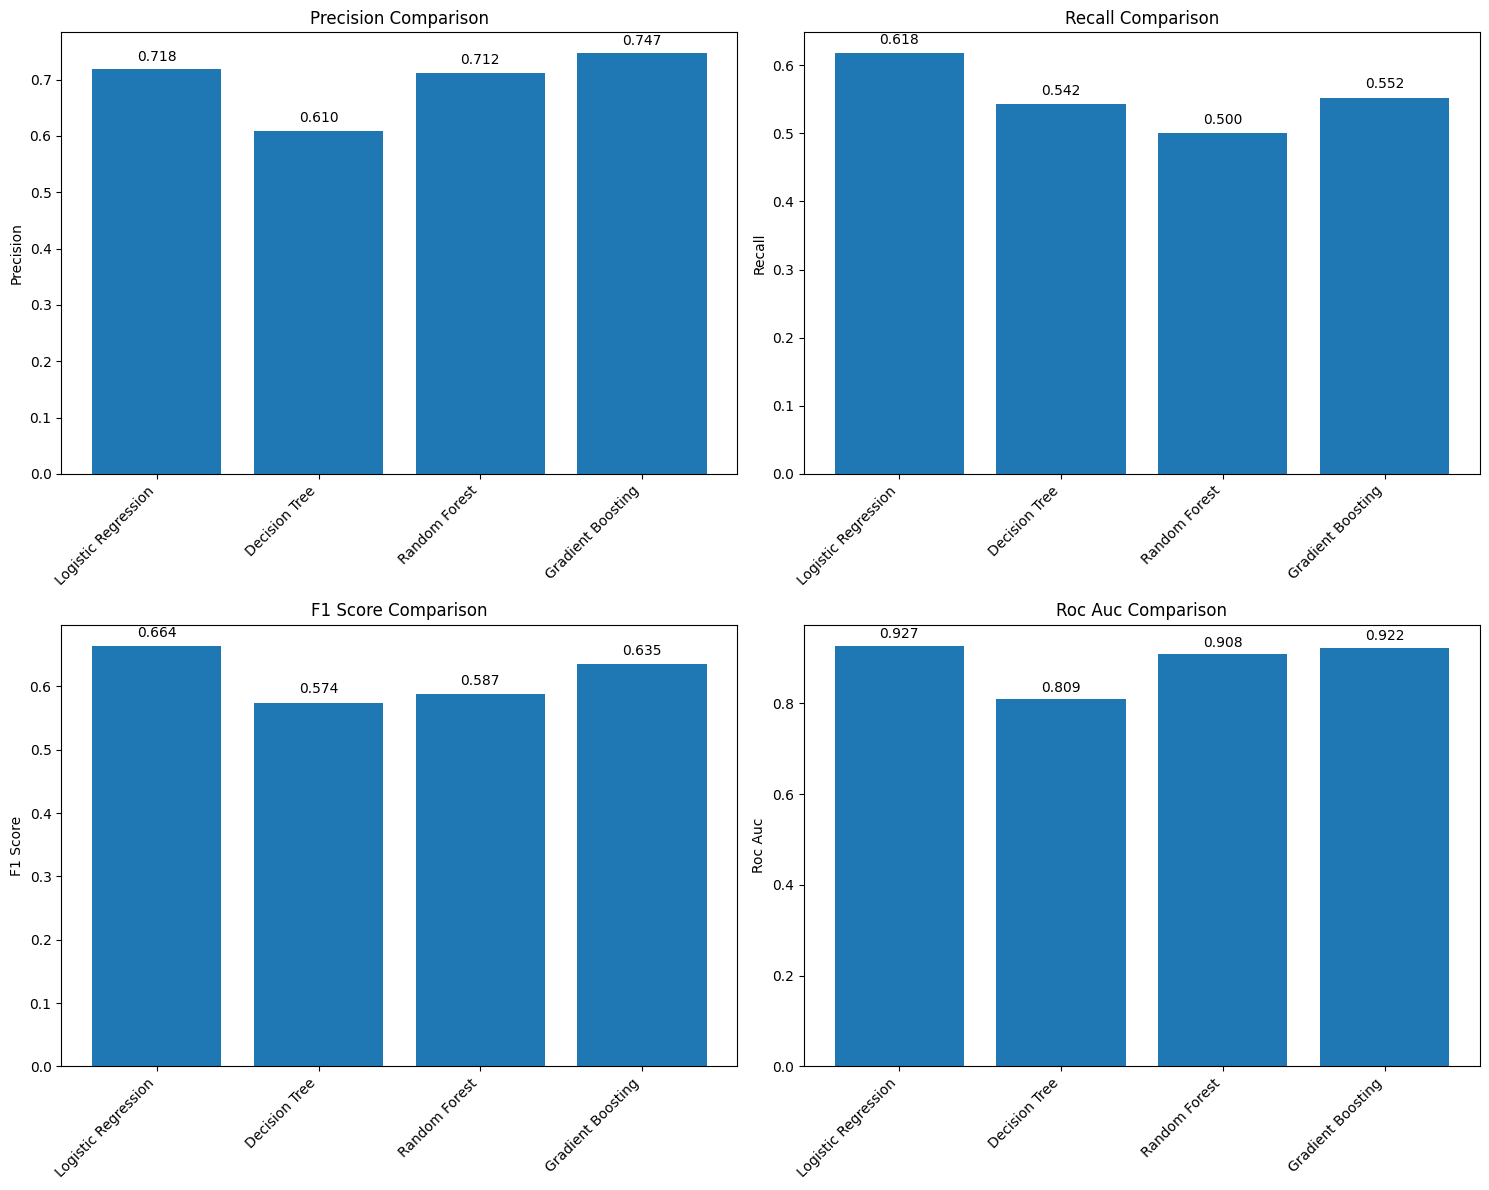

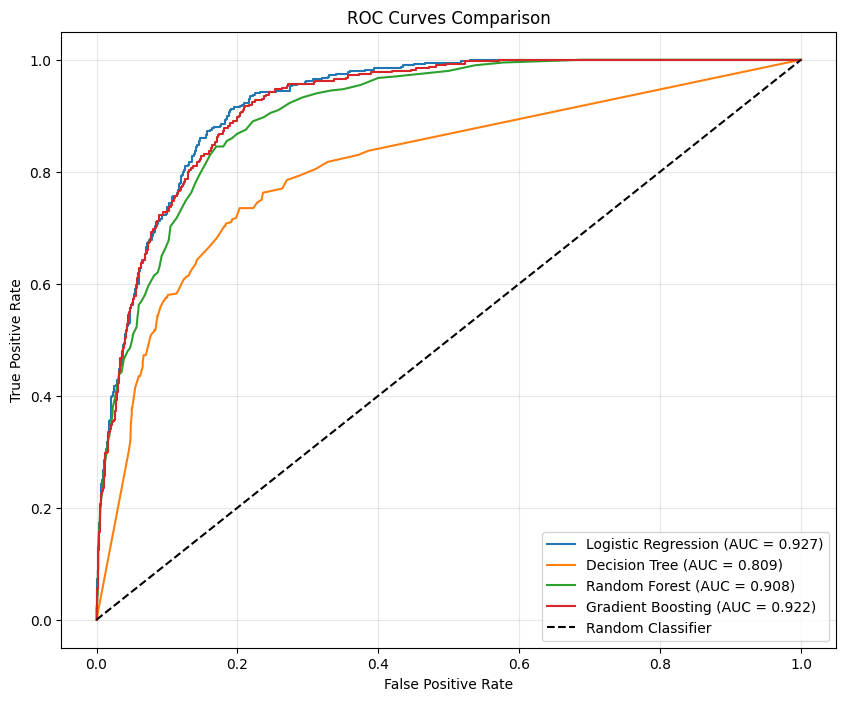

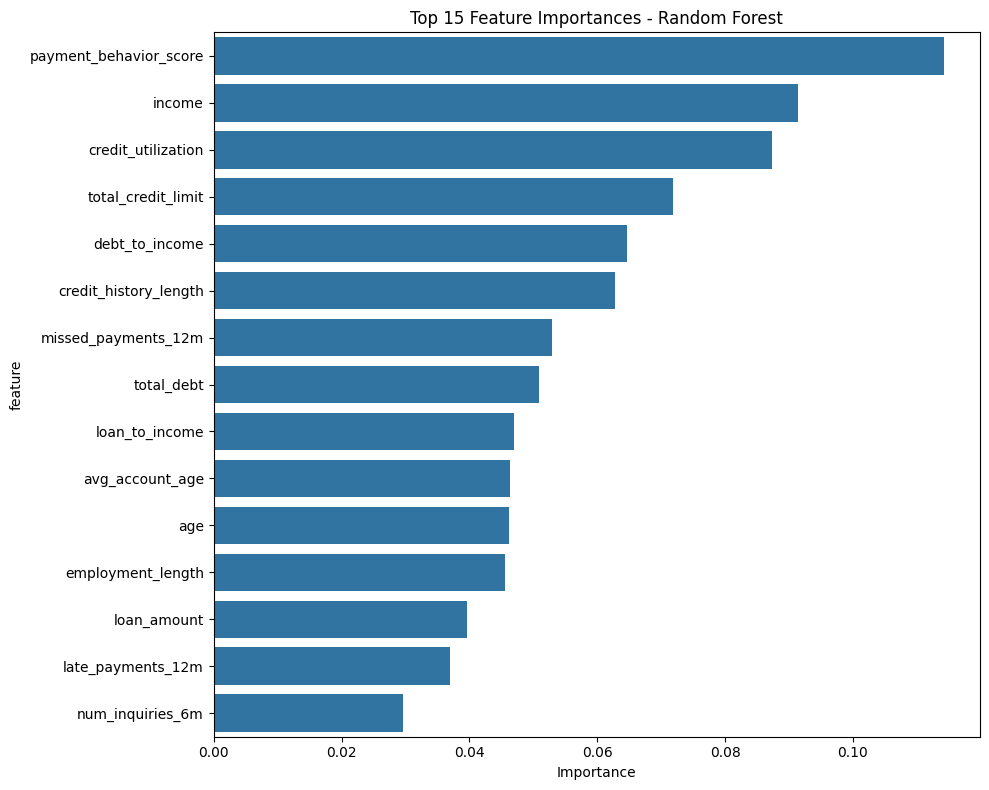

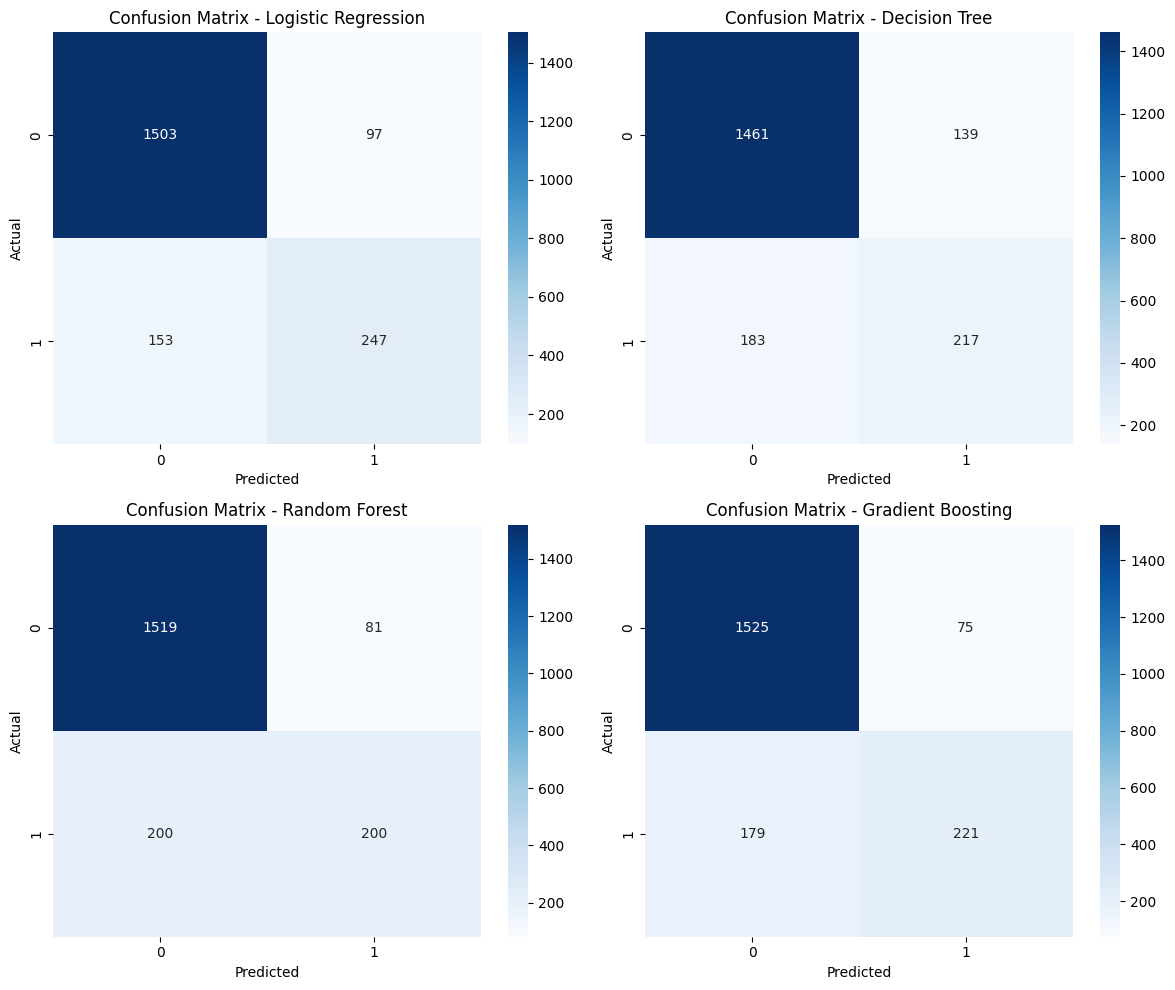


Generating comprehensive report...
CREDIT SCORING MODEL REPORT - Random Forest

Model Performance Metrics:
  Precision: 0.712
  Recall: 0.500
  F1-Score: 0.587
  ROC-AUC: 0.908

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1600
           1       0.71      0.50      0.59       400

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000


Business Interpretation:
  - Precision (71.2%): Of all predicted defaults, 71.2% were actual defaults
  - Recall (50.0%): Of all actual defaults, 50.0% were correctly identified
  - F1-Score (0.587): Harmonic mean of precision and recall
  - ROC-AUC (0.908): Model's ability to distinguish between classes
  ✓ Excellent model performance


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           precision_score, recall_score, f1_score,
                           roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

class CreditScoringModel:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.feature_names = []

    def generate_sample_data(self, n_samples=10000):
        """Generate realistic credit scoring dataset"""
        np.random.seed(42)

        # Generate correlated features
        data = {}

        # Basic demographics
        data['age'] = np.random.normal(40, 12, n_samples).clip(18, 80)
        data['income'] = np.random.lognormal(10.5, 0.8, n_samples).clip(20000, 500000)

        # Credit history features
        data['credit_history_length'] = np.random.normal(8, 4, n_samples).clip(0, 30)
        data['num_credit_accounts'] = np.random.poisson(4, n_samples).clip(0, 20)
        data['total_credit_limit'] = data['income'] * np.random.uniform(0.5, 3.0, n_samples)

        # Debt and utilization
        data['total_debt'] = data['total_credit_limit'] * np.random.beta(2, 5, n_samples)
        data['credit_utilization'] = data['total_debt'] / data['total_credit_limit']

        # Payment history
        data['late_payments_12m'] = np.random.poisson(1, n_samples).clip(0, 12)
        data['missed_payments_12m'] = np.random.poisson(0.5, n_samples).clip(0, 6)

        # Employment and stability
        data['employment_length'] = np.random.exponential(5, n_samples).clip(0, 40)
        data['num_inquiries_6m'] = np.random.poisson(2, n_samples).clip(0, 15)

        # Loan specifics
        data['loan_amount'] = np.random.lognormal(9.5, 0.7, n_samples).clip(1000, 100000)
        data['loan_term'] = np.random.choice([12, 24, 36, 48, 60], n_samples,
                                           p=[0.1, 0.2, 0.4, 0.2, 0.1])

        # Home ownership
        data['home_ownership'] = np.random.choice(['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
                                                n_samples, p=[0.4, 0.2, 0.35, 0.05])

        # Loan purpose
        data['loan_purpose'] = np.random.choice(['debt_consolidation', 'credit_card',
                                               'home_improvement', 'major_purchase',
                                               'medical', 'car', 'other'], n_samples,
                                               p=[0.3, 0.2, 0.15, 0.1, 0.1, 0.1, 0.05])

        # Create target variable based on realistic risk factors
        risk_score = (
            -0.01 * data['age'] +
            -0.00002 * data['income'] +
            -0.05 * data['credit_history_length'] +
            2.0 * data['credit_utilization'] +
            0.3 * data['late_payments_12m'] +
            0.5 * data['missed_payments_12m'] +
            -0.02 * data['employment_length'] +
            0.1 * data['num_inquiries_6m'] +
            np.random.normal(0, 0.5, n_samples)
        )

        # Convert to binary classification (0 = good credit, 1 = bad credit)
        data['default'] = (risk_score > np.percentile(risk_score, 80)).astype(int)

        return pd.DataFrame(data)

    def feature_engineering(self, df):
        """Create additional features from existing ones"""
        df = df.copy()

        # Debt-to-income ratio
        df['debt_to_income'] = df['total_debt'] / df['income']

        # Credit utilization bins
        df['utilization_high'] = (df['credit_utilization'] > 0.7).astype(int)
        df['utilization_medium'] = ((df['credit_utilization'] > 0.3) &
                                   (df['credit_utilization'] <= 0.7)).astype(int)

        # Age groups
        df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100],
                                labels=['young', 'middle', 'mature', 'senior'])

        # Income groups
        df['income_group'] = pd.cut(df['income'], bins=[0, 40000, 70000, 120000, np.inf],
                                   labels=['low', 'medium', 'high', 'very_high'])

        # Payment behavior score
        df['payment_behavior_score'] = (df['late_payments_12m'] * 0.5 +
                                       df['missed_payments_12m'] * 1.0)

        # Credit experience
        df['avg_account_age'] = df['credit_history_length'] / (df['num_credit_accounts'] + 1)

        # Loan-to-income ratio
        df['loan_to_income'] = df['loan_amount'] / df['income']

        return df

    def preprocess_data(self, df):
        """Preprocess the data for model training"""
        df = self.feature_engineering(df)

        # Encode categorical variables
        le_home = LabelEncoder()
        le_purpose = LabelEncoder()
        le_age_group = LabelEncoder()
        le_income_group = LabelEncoder()

        df['home_ownership_encoded'] = le_home.fit_transform(df['home_ownership'])
        df['loan_purpose_encoded'] = le_purpose.fit_transform(df['loan_purpose'])
        df['age_group_encoded'] = le_age_group.fit_transform(df['age_group'])
        df['income_group_encoded'] = le_income_group.fit_transform(df['income_group'])

        # Select features for modeling
        feature_cols = [
            'age', 'income', 'credit_history_length', 'num_credit_accounts',
            'total_credit_limit', 'total_debt', 'credit_utilization',
            'late_payments_12m', 'missed_payments_12m', 'employment_length',
            'num_inquiries_6m', 'loan_amount', 'loan_term',
            'debt_to_income', 'utilization_high', 'utilization_medium',
            'payment_behavior_score', 'avg_account_age', 'loan_to_income',
            'home_ownership_encoded', 'loan_purpose_encoded',
            'age_group_encoded', 'income_group_encoded'
        ]

        X = df[feature_cols]
        y = df['default']

        self.feature_names = feature_cols

        return X, y

    def train_models(self, X, y):
        """Train multiple classification models"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Initialize models
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
        }

        # Train and evaluate models
        results = {}

        for name, model in models.items():
            print(f"Training {name}...")

            # Use scaled data for Logistic Regression, original for tree-based models
            if name == 'Logistic Regression':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            results[name] = {
                'model': model,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"{name} - Precision: {precision:.3f}, Recall: {recall:.3f}, "
                  f"F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

        self.models = results
        return results

    def plot_model_comparison(self):
        """Plot comparison of model performance"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Metrics comparison
        models = list(self.models.keys())
        metrics = ['precision', 'recall', 'f1_score', 'roc_auc']

        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]
            values = [self.models[model][metric] for model in models]
            bars = ax.bar(models, values)
            ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
            ax.set_ylabel(metric.replace("_", " ").title())
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(10, 8))

        for name, results in self.models.items():
            fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
            plt.plot(fpr, tpr, label=f"{name} (AUC = {results['roc_auc']:.3f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_feature_importance(self, model_name='Random Forest'):
        """Plot feature importance for tree-based models"""
        if model_name not in self.models:
            print(f"Model {model_name} not found")
            return

        model = self.models[model_name]['model']

        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

            return feature_importance
        else:
            print(f"Model {model_name} doesn't have feature_importances_ attribute")

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()

        for i, (name, results) in enumerate(self.models.items()):
            cm = confusion_matrix(results['y_test'], results['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
            axes[i].set_title(f'Confusion Matrix - {name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def generate_credit_report(self, model_name='Random Forest'):
        """Generate a comprehensive credit scoring report"""
        if model_name not in self.models:
            print(f"Model {model_name} not found")
            return

        results = self.models[model_name]

        print("="*60)
        print(f"CREDIT SCORING MODEL REPORT - {model_name}")
        print("="*60)

        print(f"\nModel Performance Metrics:")
        print(f"  Precision: {results['precision']:.3f}")
        print(f"  Recall: {results['recall']:.3f}")
        print(f"  F1-Score: {results['f1_score']:.3f}")
        print(f"  ROC-AUC: {results['roc_auc']:.3f}")

        print(f"\nDetailed Classification Report:")
        print(classification_report(results['y_test'], results['y_pred']))

        # Business interpretation
        print(f"\nBusiness Interpretation:")
        print(f"  - Precision ({results['precision']:.1%}): Of all predicted defaults, "
              f"{results['precision']:.1%} were actual defaults")
        print(f"  - Recall ({results['recall']:.1%}): Of all actual defaults, "
              f"{results['recall']:.1%} were correctly identified")
        print(f"  - F1-Score ({results['f1_score']:.3f}): Harmonic mean of precision and recall")
        print(f"  - ROC-AUC ({results['roc_auc']:.3f}): Model's ability to distinguish between classes")

        if results['roc_auc'] >= 0.8:
            print("  ✓ Excellent model performance")
        elif results['roc_auc'] >= 0.7:
            print("  ✓ Good model performance")
        elif results['roc_auc'] >= 0.6:
            print("  ⚠ Fair model performance")
        else:
            print("  ✗ Poor model performance")


# Example usage
def main():
    print("Credit Scoring Model Implementation")
    print("="*50)

    # Initialize the model
    credit_model = CreditScoringModel()

    # Generate sample data
    print("Generating sample credit data...")
    df = credit_model.generate_sample_data(10000)

    print(f"Dataset shape: {df.shape}")
    print(f"Default rate: {df['default'].mean():.2%}")

    # Preprocess data
    print("\nPreprocessing data...")
    X, y = credit_model.preprocess_data(df)

    # Train models
    print("\nTraining models...")
    results = credit_model.train_models(X, y)

    # Generate visualizations
    print("\nGenerating visualizations...")
    credit_model.plot_model_comparison()
    credit_model.plot_roc_curves()
    credit_model.plot_feature_importance()
    credit_model.plot_confusion_matrices()

    # Generate report
    print("\nGenerating comprehensive report...")
    credit_model.generate_credit_report('Random Forest')

    return credit_model, df

if __name__ == "__main__":
    model, data = main()